### qubit freq vs gate repeatibilty
'''you need to use datanalyzer from Malthe, or download from github'''

In [ ]:
# package import
import dataanalyzer as da
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import scipy
import glob
import matplotlib.pyplot as plt

#### check file name and produce a new filename

In [ ]:
def uniquify(path) -> str:
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = f"{filename}_{str(counter)}{extension}"
        counter += 1

    return path

In [ ]:
# constants for dataanalyzer's functions
r = np.random.RandomState(0)
XRES, YRES = 1, 2
SIGMALIMIT = 10e7

#### 1. functions definition

In [ ]:
# define functions to extract the data from the datafiles
def make_df_from_filepaths(filepaths, xname="gate", yname="S21 frequency", zname="S21 Magnitude"):
    """Make pandas dataframe from filepaths"""
    df = pd.DataFrame()
    for i, filepath in enumerate(filepaths):
        dfi = pd.read_csv(filepath, sep="\t", skiprows=3, names=[xname, yname, zname, "Iteration"])
        dfi["Iteration"] = i
        df = pd.concat([df, dfi])
    return df




def get_xyZ_data(
    df, iterations=None, xres=XRES, yres=YRES, xname="gate", yname="S21 frequency", zname="S21 Magnitude"
):
    """Get x, y, and Z data from dataframe"""

    if iterations is None:
        iterations = df["Iteration"].unique()
    if not isinstance(iterations, list):
        iterations = [iterations]

    output = []
    for it in iterations:
        dfi = df[df["Iteration"] == it]
        x = dfi[xname].unique()
        y = dfi[yname].unique()
        Z = dfi[zname].values.reshape(len(x), len(y)).T
        output.append((x[::xres], y[::yres], Z[::yres, ::xres]))
    return output


def convert_value_error_dict_to_list(value_error_list_of_dicts):
    """Convert value error dict to list"""
    value_list = []
    error_list = []
    for value_error_dict in value_error_list_of_dicts:
        value_list.append(value_error_dict["value"])
        error_list.append(value_error_dict["error"])
    return value_list, error_list



def convert_output(output_list):
    output_list = np.array(output_list)
    output = [convert_value_error_dict_to_list(outlist) for outlist in output_list]
    return np.array(output)

##### fitting function

In [ ]:
def fit_one_resonator_sweep(
    df,
    iterations=None,
    xname="gate",
    yname="S21 frequency",
    zname="S21 Magnitude",
    yerr=None,
    limits=None,
    inital_guess=None,
):
    """Fit resonators to the data"""

    if iterations is None:
        iterations = list(df["Iteration"].unique())
    if not isinstance(iterations, list):
        iterations = [iterations]

    if inital_guess is None:
        inital_guess = {}

    # Set up the model
    model = da.fitmodels.LorentzianConstantModel(negative_peak=False)

    # Fit peaks with lorentzian for each gate
    centers, sigmas = [], []

    for it in iterations:
        dfi = df[df["Iteration"] == it]

        centers_i, sigmas_i = [], []

        for gate_voltage in tqdm(dfi[xname].unique()):
            gate = dfi[dfi[xname] == gate_voltage]
            center, sigma, _ = fit_resonator(gate[yname], gate[zname], yerr, model, inital_guess)

            centers_i.append(center)
            sigmas_i.append(sigma)

        centers.append(centers_i)
        sigmas.append(sigmas_i)

    return convert_output(centers), convert_output(sigmas)


def fit_resonator(x, y, yerr, model, initial_guess):
    """Fit resonator to the data"""
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)

    fit = da.Fitter(x=x, y=y, model=model, yerr=yerr)
    # fit.set_initial_guess(**initial_guess_dict)
    fit.set_initial_guess(**initial_guess)
    fit.set_initial_guess(center=x[np.argmax(y)])

    # fit.set_initial_guess(sigma={"limits": np.array([0.0, SIGMALIMIT])})
    # if initial_guess_dict != {}:
    #     fit.set_initial_guess(
    #         center={
    #             "limits": np.array(
    #                 [
    #                     initial_guess_dict["center"] - CENTERJUMPLIMIT,
    #                     initial_guess_dict["center"] + CENTERJUMPLIMIT,
    #                 ]
    #             )
    #         }
    #     )

    fit.do_fit()
    return (
        fit.get_parameters()["center"],
        fit.get_parameters()["sigma"],
        fit.get_values("amplitude", "center", "sigma"),
    )


#### 2. load the data from data folder

In [ ]:
# Get all folders in data directory
FOLDERS = glob.glob("data/*")
FILENAME = "keithley_volt_set_S21_frequency_set.dat"
FILENAME = "keithley_volt_set_SPEC_frequency_set.dat"
FILEPATHS = [folder + "/" + FILENAME for folder in FOLDERS]


# Make pandas dataframe from all filepaths
df = make_df_from_filepaths(FILEPATHS)

# Get the data from the first iteration
x, y, Z = get_xyZ_data(df, iterations=2)[0]

# Determine voltage uncertainty
VERROR = Z[:3000, 0].std()


#### 3. plot qubit spectroscopy fit

In [ ]:
n = 0
yval = da.Valueclass(value=y, name="S21 Frequency", unit="Hz")
zval = da.Valueclass(value=Z[:, n], name="S21 Magnitude", unit="dB")
fit = da.Fitter(x=yval, y=zval, model=da.fitmodels.LorentzianConstantModel(negative_peak=False), yerr=VERROR)
fit.do_fit()
fit.minuit.migrad()
fit.minuit.hesse()

plot = da.Plotter()
plot.errorbar(y, Z[:, n], yerr=VERROR, label="Data", alpha=0.1)
plot.plot_fit(fit, plot_data=False)
plot.ax.set_title(f"Single resonator fit (gate = {x[n]:.2f} V)")
plot.show()

guess = fit.get_values("amplitude", "center", "sigma")



#### 4.find peaks for all the gates

In [ ]:
# Fit peaks with lorentzian for each gate
centers, sigmas = fit_one_resonator_sweep(df, yerr=VERROR, inital_guess=guess)

In [ ]:
centers[0][0]

### 5.0 plot for only one 2D scan

In [ ]:
it = 2
x, y, Z = np.squeeze(get_xyZ_data(df, iterations=it)) # x, y, Z are the gate, drive frequency and S21 data respectively

plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y/1e9, Z, cmap="bone")
plt.plot(x, centers[it][0]/1e9, label=f"Iter {it}", color="C1", linewidth=2)
plt.xlabel("Gate Voltage [V]", fontsize=20)
plt.ylabel("Drive Frequency [GHz]", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
cbar = plt.colorbar()
cbar.set_label("Readout signal [a.u]", labelpad=15, fontsize=20)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)

# figure saving
filenameInthePath = uniquify(path="pdfFolder/DriveFreqvsGatescan2D.pdf")
plt.savefig(filenameInthePath)
plt.show()

# data saving
gate, drive_freq, S21 = x, y, Z
filenameInthePath = uniquify(path="txtFolder/gate_voltage_list")
np.savetxt(filenameInthePath, gate) # 1D
filenameInthePath = uniquify(path="txtFolder/drive_frequency")
np.savetxt(filenameInthePath, drive_freq) # 1D, in Hz
filenameInthePath = uniquify(path="txtFolder/S21_signal_dB")
np.savetxt(filenameInthePath, S21) # S21 is the 2D array
filenameInthePath = uniquify(path="txtFolder/extracted_qubit_freq")
np.savetxt(filenameInthePath, centers[it][0])


#### 5.1 run this one to plot the 2D data if you wanna select the gate window to be [0, 2V]
''' the qubit peaks from -0.5V to 0 is not as profound as 0 to 2V, which makes the fitting not accurate '''

In [ ]:
it = 2
x, y, Z = np.squeeze(get_xyZ_data(df, iterations=it))
x_lim = x[x>0]
y_lim = y[y>4.4e9]
Z_lim = Z[y>4.4e9, :][:, x>0]
centers_lim = centers[it][0][x>0]

plt.figure(figsize=(7, 5))
plt.pcolormesh(x_lim, y_lim/1e9, Z_lim, cmap="bone")
plt.plot(x_lim, centers_lim/1e9, label=f"Iter {it}", color="C1", linewidth=2)
plt.xlabel("Gate Voltage [V]", fontsize=20)
plt.ylabel("Drive Frequency [GHz]", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
cbar = plt.colorbar()
cbar.set_label("Readout signal [a.u]", labelpad=15, fontsize=20)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
plt.legend()
filenameInthePath = uniquify(path="pdfFolder/DriveFreqvsGatescan2DLim.pdf")
plt.savefig(filenameInthePath)
plt.show()

# data saving, the data here is for gat drive frequency in [4.4*GHz, 6GHz]
gate, drive_freq, S21 = x_lim, y_lim, Z_lim
filenameInthePath = uniquify(path="txtFolder/gate_voltage_list_lim")
np.savetxt(filenameInthePath, gate) # 1D
filenameInthePath = uniquify(path="txtFolder/drive_frequency_lim")
np.savetxt(filenameInthePath, drive_freq) # 1D, in Hz
filenameInthePath = uniquify(path="txtFolder/S21_signal_dB_lim")
np.savetxt(filenameInthePath, S21) # S21 is the 2D array
filenameInthePath = uniquify(path="txtFolder/extracted_qubit_freq_lim")
np.savetxt(filenameInthePath, centers_lim)

#### 5.2 plot all the iterations in one plot. Each data point is the average, and errorbar is the std
''' note: I removed one datapoint because the spectroscopy didn't show any peak, the peak finder just found some random noise peak'''

In [ ]:
plt.figure(figsize=(7, 5))
freq_mean = np.mean(centers[:, 0], axis=0) # each point is the mean of n iterations
freq_std = np.std(centers[:, 0], axis=0) # each point is the std of n iterations
gate = x
gate_remove = gate[freq_std<400e6]
freq_std_remove = freq_std[freq_std<400e6]
freq_mean_remove = freq_mean[freq_std<400e6]

plt.errorbar(x=gate_remove, y=freq_mean_remove/1e9, yerr=freq_std_remove/1e9, marker='s', mfc='red',
         mec='green', ms=10, mew=2)
plt.ylabel("Drive Frequency [GHz]", fontsize=20)
plt.xlabel("Gate Voltage [V]", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
filenameInthePath = uniquify(path="pdfFolder/DriveFreqvsGatescan_mean.pdf")
plt.savefig(filenameInthePath)
plt.show()



plt.figure(figsize=(7, 5))
plt.scatter(x=gate_remove, y=freq_std_remove/1e6, marker='^', c='b')
plt.ylabel("std of 10 iters [MHz]", fontsize=20)
plt.xlabel("Gate Voltage [V]", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
filenameInthePath = uniquify(path="pdfFolder/DriveFreqvsGatescan_std.pdf")
plt.savefig(filenameInthePath)
plt.show()

#### 5.2 only plot the data in a trusted window
because the qubit peak in spectroscopy when the gate is below 0 is not so profound. we cannot trust the fitting there, ending up with bad std

In [ ]:
plt.figure(figsize=(7, 5))
freq_mean = np.mean(centers[:, 0], axis=0) # each point is the mean of n iterations
freq_std = np.std(centers[:, 0], axis=0) # each point is the std of n iterations
gate = x
gate_remove = gate[freq_std<400e6]
freq_std_remove = freq_std[freq_std<400e6]
freq_mean_remove = freq_mean[freq_std<400e6]

gate_remove_lim = gate_remove[gate_remove>0.05]
freq_std_remove_lim = freq_std_remove[gate_remove>0.05]
freq_mean_remove_lim = freq_mean_remove[gate_remove>0.05]

plt.errorbar(x=gate_remove_lim, y=freq_mean_remove_lim/1e9, yerr=freq_std_remove_lim/1e9, marker='s', mfc='red',
         mec='green', ms=10, mew=2)
plt.ylabel("Drive Frequency [GHz]", fontsize=20)
plt.xlabel("Gate Voltage [V]", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
filenameInthePath = uniquify(path="pdfFolder/DriveFreqvsGatescanmeanLim.pdf")
plt.savefig(filenameInthePath)
plt.show()



plt.figure(figsize=(7, 5))
plt.scatter(x=gate_remove_lim, y=freq_std_remove_lim/1e6, marker='^', c='b')
plt.ylabel("std of 10 iters [MHz]", fontsize=20)
plt.xlabel("Gate Voltage [V]", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
filenameInthePath = uniquify(path="pdfFolder/DriveFreqvsGatescanstdLim.pdf")
plt.savefig(filenameInthePath)
plt.show()


# data saving
filenameInthePath = uniquify(path="txtFolder/gate_remove_lim") # the gate is in [0, 2], one data point is removed because there us no peak in spectroscopy
np.savetxt(filenameInthePath, gate_remove_lim)
filenameInthePath = uniquify(path="txtFolder/freq_mean_remove_lim")
np.savetxt(filenameInthePath, freq_mean_remove_lim)
filenameInthePath = uniquify(path="txtFolder/freq_std_remove_lim")
np.savetxt(filenameInthePath, freq_std_remove_lim)

#### data plotting wihout data analyzer

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data:
gate = np.loadtxt("txtFolder/gate_voltage_list_lim")
drive_freq = np.loadtxt("txtFolder/drive_frequency_lim")
S21 = np.loadtxt("txtFolder/S21_signal_dB_lim")
extracted_qubit_freq = np.loadtxt("txtFolder/extracted_qubit_freq_lim")

FileNotFoundError: txtFolder/gate_voltage_list_lim not found.

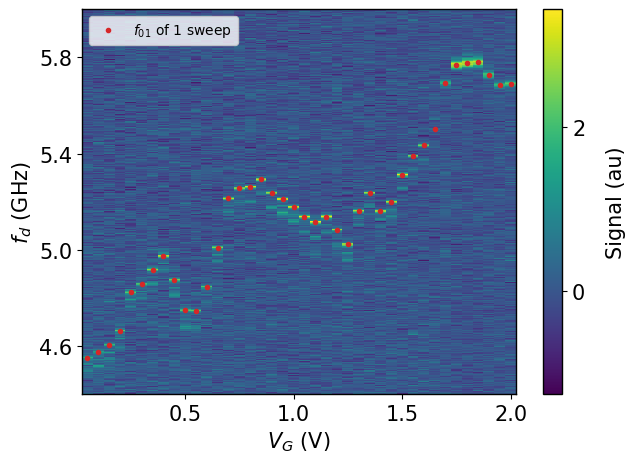

In [91]:
# Update plotstyle
plt.style.use("presentation.mplstyle") # path to the style file

# Normalize the S21 data:
S21_norm = np.array([S21[:,idx] - np.mean(S21[:, idx]) for idx in range(len(gate))])


# Start the figure:
plt.figure(figsize=(7, 5))

plt.pcolormesh(gate, drive_freq/1e9, S21_norm.transpose(), cmap="viridis") # Add 2D data
plt.plot(gate, extracted_qubit_freq/1e9, color="C3", linewidth=0, marker ='o', markersize = 3, label = '$f_{01}$ of 1 sweep') # Add extracted qubit frequency

plt.xlabel("$V_G$ (V)")
plt.ylabel("$f_d$ (GHz)")
plt.yticks(np.linspace(4.6,5.8,4))
plt.grid(None)
plt.legend(loc = 2, fontsize = 10)

cbar = plt.colorbar(ticks = [0, 2])
cbar.set_label("Signal (au)", labelpad=15)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)

plt.savefig("2D_qubit_freq.png", format="png", bbox_inches="tight")

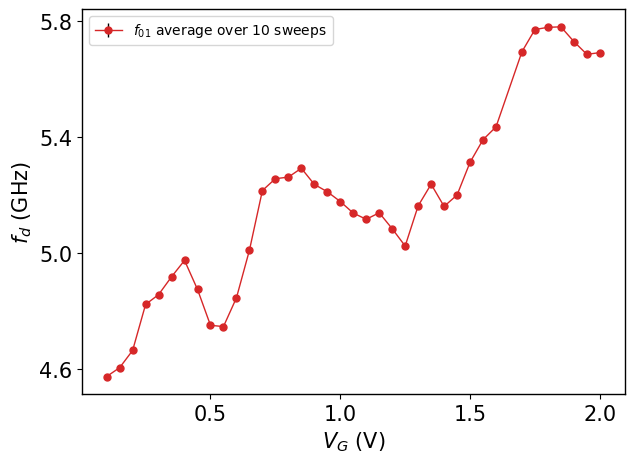

In [129]:
# 10 iteration averaged qubit freq vs gate
gate = np.loadtxt("txtFolder/gate_remove_lim")
qubit_freq_mean = np.loadtxt("txtFolder/freq_mean_remove_lim")
qubit_freq_std = np.loadtxt("txtFolder/freq_std_remove_lim")

plt.figure(figsize=(7, 5))
plt.errorbar(x=gate, y=qubit_freq_mean/1e9, yerr=qubit_freq_std/1e9, marker='o', 
             color='C3', ms=5, linewidth = 1, label = '$f_{01}$ average over 10 sweeps', ecolor = 'k', elinewidth = 1)

plt.ylabel("$f_d$ (GHz)")
plt.xlabel("$V_G$ (V)")
plt.yticks(np.linspace(4.6,5.8,4))
plt.yticks()
plt.grid(None)
plt.xticks()
plt.legend(loc = 2, fontsize = 10)

plt.savefig("qubit_freq_10_avgs.pdf", format="pdf", bbox_inches="tight", transparent = True)

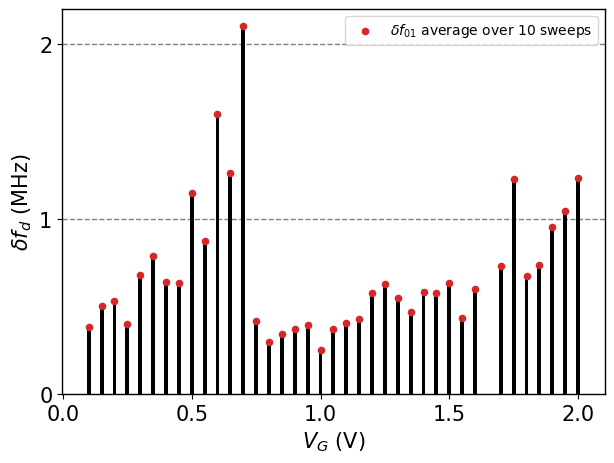

In [161]:
# 10 iteration averaged qubit freq vs gate
gate = np.loadtxt("txtFolder/gate_remove_lim")
qubit_freq_mean = np.loadtxt("txtFolder/freq_mean_remove_lim")
qubit_freq_std = np.loadtxt("txtFolder/freq_std_remove_lim")

plt.figure(figsize=(7, 5))
# plt.scatter(x=gate, y=qubit_freq_std/1e6, marker='x', 
             # color='k', linewidth = 1, s = 40, label = '$\delta f_{01}$ average over 10 sweeps')

plt.bar(x=gate, height=qubit_freq_std/1e6, width = 0.015, color = 'k')
plt.scatter(x=gate, y=qubit_freq_std/1e6, color = 'C3', s = 20, label = '$\delta f_{01}$ average over 10 sweeps')

plt.ylabel("$\delta f_d$ (MHz)")
plt.xlabel("$V_G$ (V)")
plt.yticks(np.linspace(0,2,3))
plt.yticks()
plt.ylim(0,2.2)
plt.grid(None)
plt.xticks()
plt.legend(loc = 1, fontsize = 10)
plt.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 1, zorder = -1)
plt.axhline(y = 2, color = 'gray', linestyle = '--', linewidth = 1, zorder = -1)

plt.savefig("qubit_freq_10_avgs_std.pdf", format="pdf", bbox_inches="tight", transparent = True)